In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.317347 -0.587232 -0.709863  0.444262  0.222598 -0.924368 -1.045306   
  1   0.431673  0.863269 -0.055665  0.272947  0.261737  0.211362  0.065178   
  2   0.460909 -0.207159 -0.383167  0.394941 -0.572963 -0.354522 -0.907466   
  3  -0.768497 -0.797472 -0.983797 -0.434383 -0.325198 -0.203042 -1.122561   
  4  -0.084783  0.155145  0.508193  0.191202  0.029600  0.215591 -1.469409   
  5   0.414696 -0.602184  0.797122  1.272443  0.605581  1.118794 -0.899213   
  6   0.156662 -0.321673 -0.581631  0.843565  0.211363  0.062773 -0.649792   
  7  -0.243150 -0.795129  0.338955 -1.060435 -0.765891 -0.327000 -0.996905   
  8   0.287589 -0.537388  0.671128  0.158940 -1.001659  0.526806 -0.060146   
  9  -0.274374  0.660209 -0.711037  0.006300  0.475233 -0.188009 -1.016950   
  10  0.094949  0.080325 -0.352674 -0.782641 -0.954611  0.320511 -0.800730   
  11 -0.822355 -0.560015  0.022195  0.488926 -0.529813 -0.352418 -0.429979   
  12 -0.715475 -0.489230  0.502951  0.227818 -0.534745 -1.284199 -0.836184   
  13 -1.197381 -0.897798 -0.147485  0.243856  0.057779  0.243621 -1.136350   
  14  1.345414  0.844218  0.245845 -0.141572 -0.096359 -0.091226 -0.201989   
  15  0.149440 -1.001794 -0.435081  0.323246 -0.724549 -0.064095 -1.640894   
  16 -0.801673  0.352527 -0.270994  0.286040  0.614465  0.512514 -1.130789   
  17 -1.033775 -0.689570 -0.525635 -0.133753 -0.756319 -0.626420 -1.071609   
  18 -0.829161 -0.459281  0.145803  0.726494 -0.287806 -0.552046 -0.588740   
  19 -0.472029 -0.104344  1.124511  0.367249 -1.384822  0.955304 -0.032384   
  20 -0.139502 -0.090449  0.622666  0.841795 -0.759498  0.043570 -0.572375   
  21 -0.477503 -0.982218  0.708742  0.627667 -0.276887  0.516597 -0.458010   
  22 -0.257613  0.024345  0.507576  0.070571 -1.453638 -0.314406 -0.245319   
  23  0.040375 -0.016381 -0.144628  0.136227 -0.259477 -0.724188 -1.530142   
  24 -0.632097 -0.579942 -0.264468  0.506500 -0.629397  0.223455 -0.000880   
1 0   0.216625 -0.313640 -0.908450 -1.160267  0.063144 -0.101831  0.359821   
  1   0.110681  1.054503  0.267615  0.531081 -0.008583 -0.741160  0.172352   
  2   0.929753  0.059676  0.674858  0.058070  0.139401 -0.233577  0.299994   
  3   0.837463  0.196014 -0.407505  0.328211 -0.173811 -0.503549 -0.339465   
  4  -0.219378  0.319590  1.015078  1.173000  0.486187  0.506486  0.434511   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -1.039270  0.379398  0.583811  ...  0.379942 -0.107895  0.048671   
  1  -0.215072 -0.332087 -0.576612  ...  0.539391  0.221914 -0.239749   
  2   0.091054  0.031266 -1.176812  ...  0.369204 -0.221613 -0.334483   
  3  -0.140579 -0.026244  0.528133  ... -0.535124 -0.777123  0.249124   
  4   0.998769  0.143100 -0.176840  ... -0.776944 -0.222924  0.245045   
  5   0.319764 -0.224876  1.281800  ...  0.729376  0.097340 -0.050351   
  6  -0.428285  0.238869  0.331650  ... -0.125967 -0.559330  1.081224   
  7  -1.076577 -0.775629  0.099678  ...  0.113904 -1.016741 -0.175039   
  8  -0.236529  0.203286  1.835551  ...  0.432349 -1.552432 -1.335206   
  9   0.027873 -0.846918 -0.497122  ... -0.136166 -0.845732 -0.275207   
  10 -0.528011  0.194660 -0.563502  ...  0.106357  0.550082  0.505556   
  11 -1.065538 -1.329982 -1.394040  ... -0.919235 -0.523760  0.340042   
  12 -1.053766 -1.210276 -1.770989  ... -0.445713 -0.616803 -0.470271   
  13  0.442816  0.400264  0.952992  ...  0.579353  0.445224  0.166674   
  14  0.107310 -0.591440 -0.241794  ...  0.203601 -0.894730 -0.030798   
  15 -0.441890 -0.710124 -0.450919  ... -0.351838 -0.121139 -0.882794   
  16  1.042320  0.172251  0.423412  ... -0.774821 -0.454674 -0.689253   
  17  0.514586 -0.683358 -0.032733  ...  1.154536 -0.652225 -0.177162   
  18 -0.347806 -0.583323 -0.181832  ... -0.253866 -1.211362  0.170790   
  19  0.216601 -0.848931  0.720318  ... -0.128780 -0.529629 -0.069870   
  20 -0.654620  0.875949 -0.431945  ...  0.545238  0.820459 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %  97.5 %
D  0.923642  0.037224  24.812906  6.505532e-136  0.850684  0.9966


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



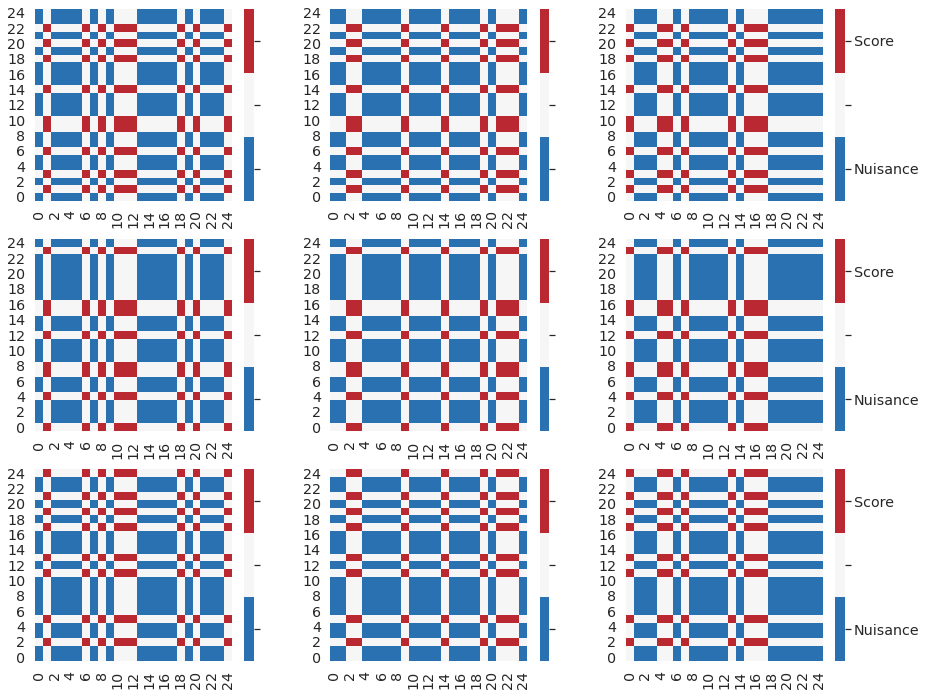

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



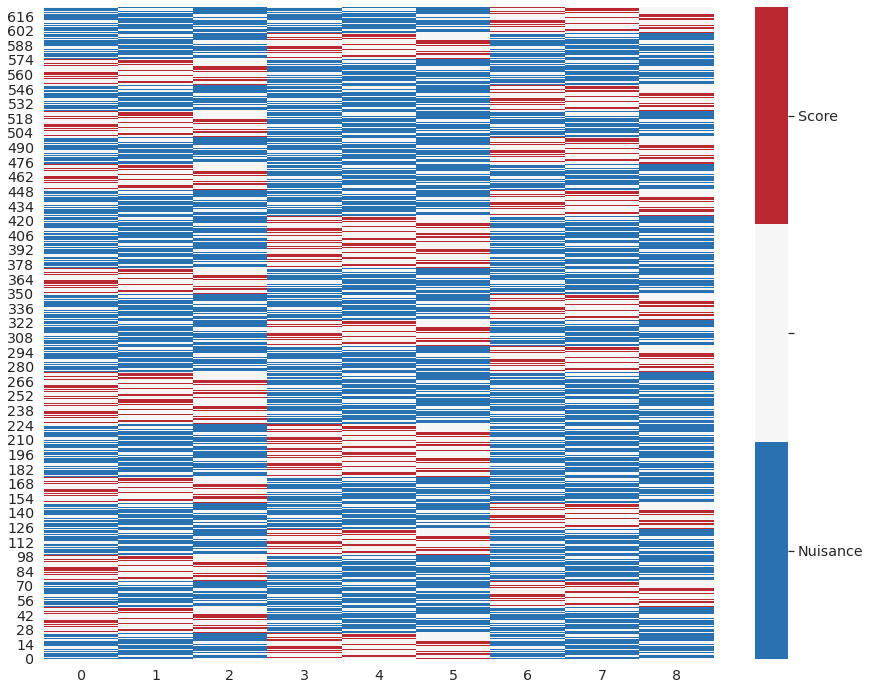

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])